**Introduction**  
In this notebook will be regarded problem of clustering on dataset that contains four features, all numerical:
- Focal depth   
- Latitude  
- Longtitude   
- Richter  

Probably features are describing geogrephical location of some objects.

Firstly will be done EDA and data preparation. Will be consdiered few algorithms for clustering, their comparison, visualizations of clustered points. At the end will be derived best clustering technique and samples from dataset will be visualized on a worldmap with coloring(according to the best clustering technique).

**Importing needed libraries**

In [ ]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 17.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score
import hdbscan

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/HW5/quake.csv'

data = pd.read_csv(file_path, sep=',')
data.head()

Mounted at /content/drive


,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
data.shape

(2178, 4)

As can be seen the dataset is rather small.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


Seems like dataframe is without missing values.

In [ ]:
data.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


Basic statistics suggest that there is no strange, missing, unnormal values in columns of dataframe.  
Can be seen that values located in feature "Richter" are not varying significantly, because standard deviation is small.  
Also can be noticed, that features take on values from different scales, ranges.

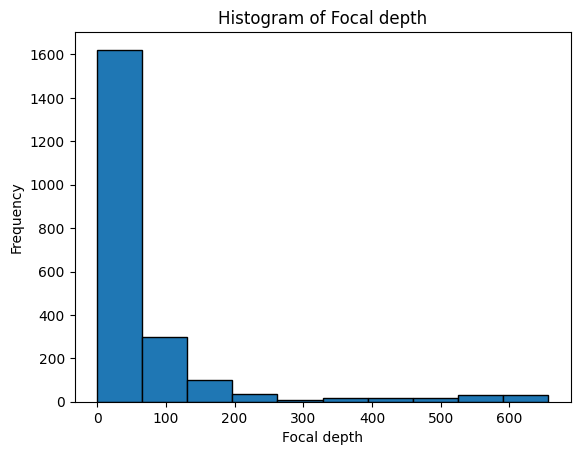

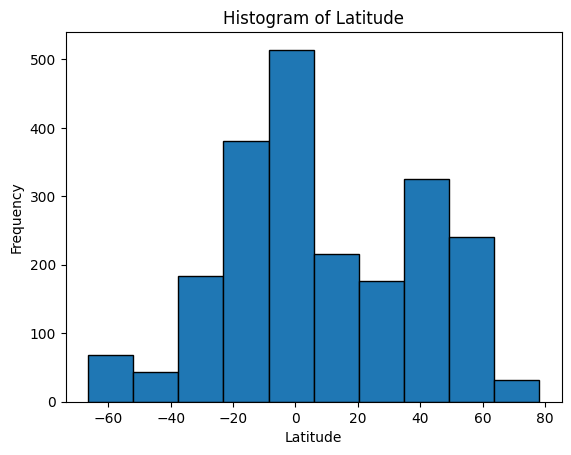

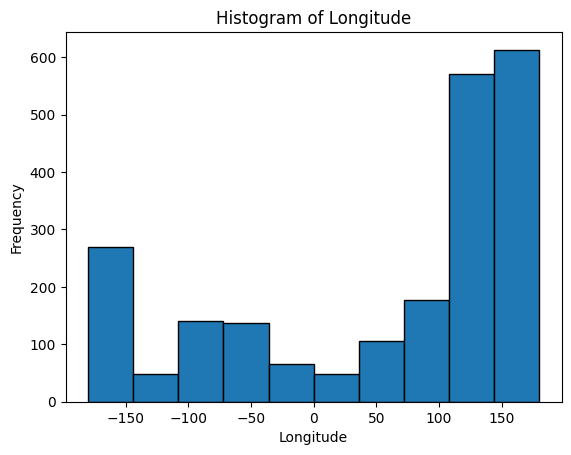

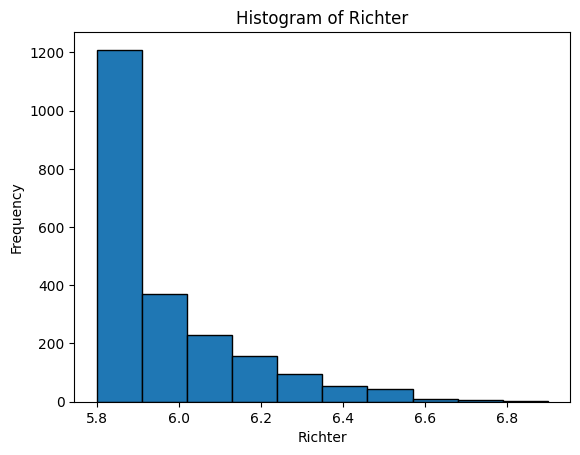

In [ ]:
for column in data.columns:
    plt.figure()
    plt.hist(data[column], edgecolor='black')
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

The feature "Focal Depth" follows distribution similar to exponential. Mostly values of this features are located in range [0; 50].  Also the distribution is right-skewed.  Looks like this feature might have significant number of outliers.

Distribution of feature "Richter" also resembles exponential distribution. As can be seen feature's distribution is also right skewed. Feature probably does not have a lot of outliers.  

Feature "Longtitude" takes on values mostly from interval [105, 180].  
Feature "Longtitude" takes on values mostly from interval [-20, 5].

Features "Longtitude" and "Latitude" seem to not follow any particular distribution. Both of them have multiple peaks. Values of both of them are symmetrical relatively of point zero.

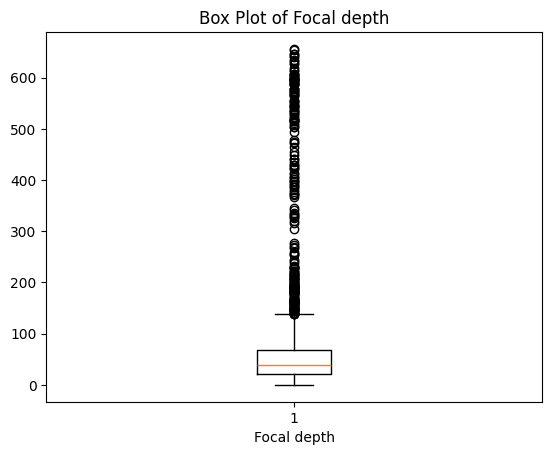

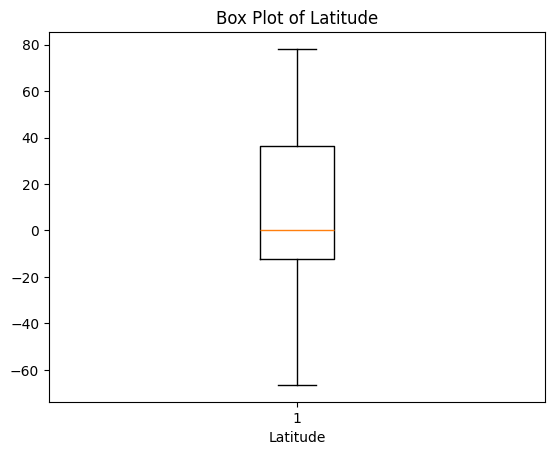

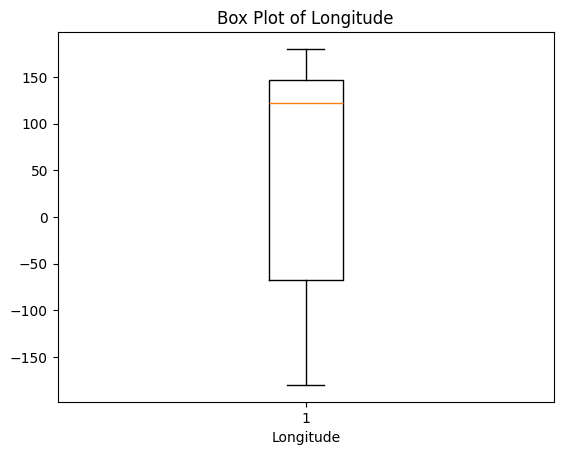

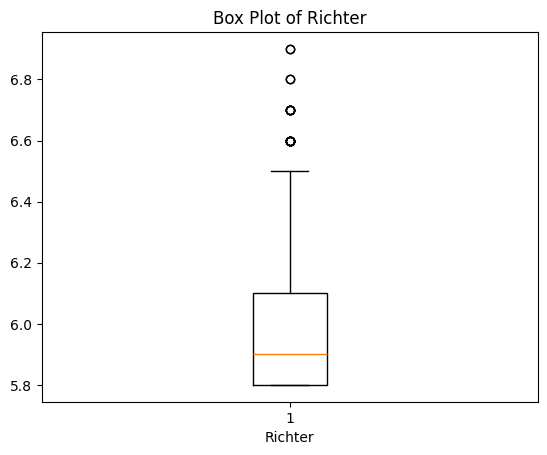

In [ ]:
for column in data.columns:
    plt.figure()
    plt.boxplot(data[column])
    plt.title(f"Box Plot of {column}")
    plt.xlabel(column)
    plt.show()

Boxplots have backed insights derived previously from histogram plots.  
As was previously mentioned, feature "Richter" has some outliers (small amount) and feature "Focal depth" contains relatively big amount of outliers.

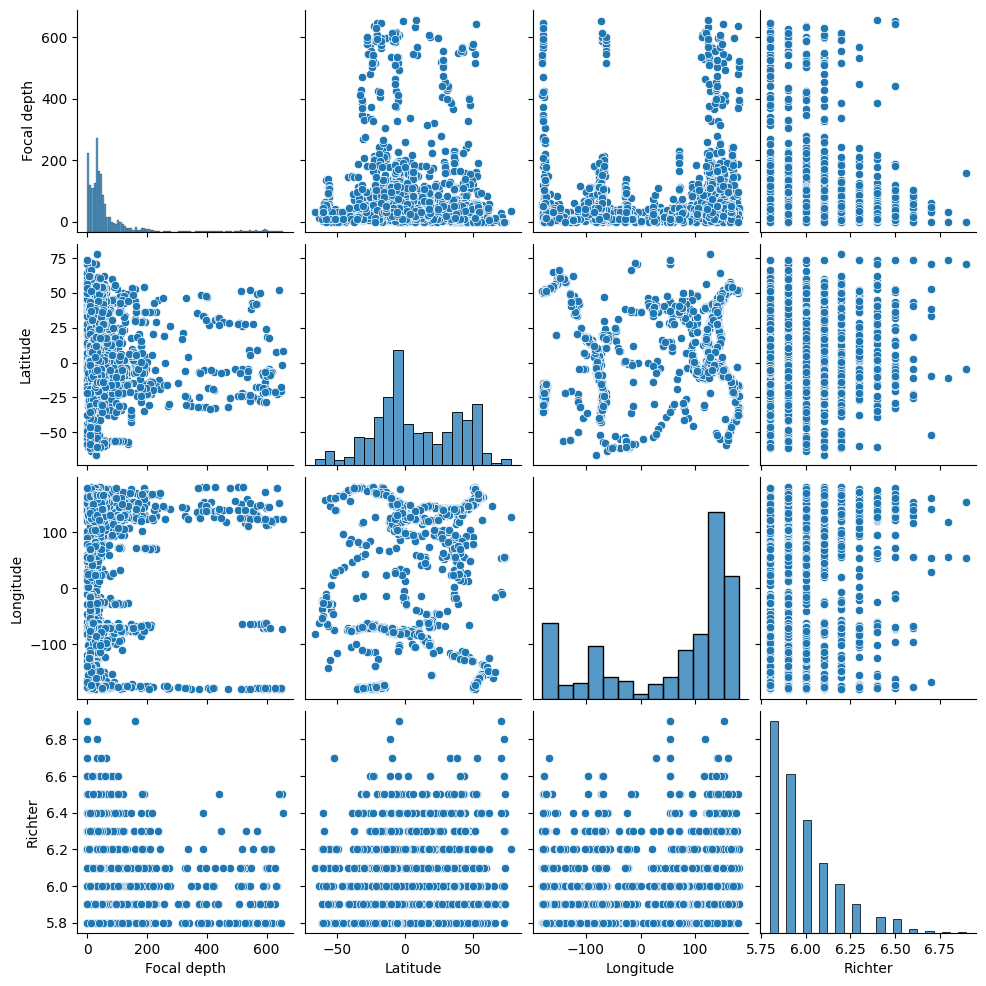

In [ ]:
sns.pairplot(data)
plt.show()

As can be seen, no particular relationship between features exists. Moreover, obvious that features are not dependent linearly (pairwise). There is no sense to plot Pearson's coefficient matrix.  
Pairplot of features "Longtitude" and "Latitude" resemble to be some map of locations.

In [ ]:
scaler = StandardScaler()
standardized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

As was seen features take on values from different ranges, their scale is different. Some clustering algorithms will be making use of distance metrics, so there is need to standardize our features before applying models (otherwise features of higher ranges will have higher impact on results of clustering, that would introduce artificial importance of such features). So , let's make them take on values from the same range.

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(standardized_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', title="3D PCA Plot of standardized data", opacity=0.7)
fig.show()

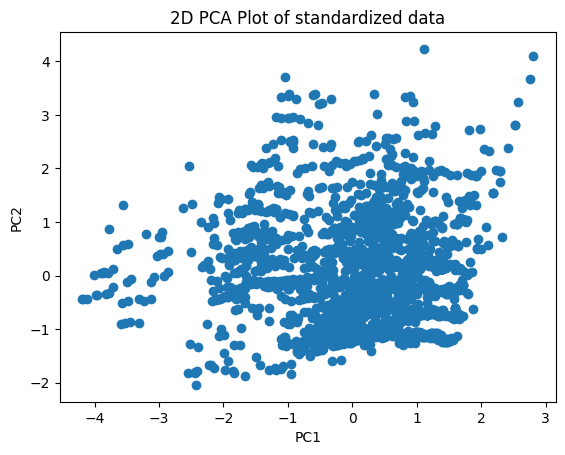

In [ ]:
plot = plt.scatter(pca_result[:,0], pca_result[:,1])
plt.title("2D PCA Plot of standardized data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

To standardized dataset was applied PCA dimensionality reduction technique, so to visualize dataset in 2 and 3 dimension space. After visualization cannot be said the amount of clusters on which dataset could be partitioned. Probably it is because of complicated dataset's inner structure. Can not be seen any clear separations (between potential clusters), boundaries of different parts of dataset(Looking at 2d plot). Though in thre dimensions some sort of separations and potential clusters are noticeable.


Internal metrics that will be used to assess quality of clustering techniques:   
Silhouette score and Calinski-Harabasz score basically measure how similar an object is to its own cluster compared to other clusters(using different approaches, as those are different metrics).

External metrics that will be used to assess quality of clustering techniques:  
Adjusted Rand Index and Adjusted Mutual Information measure similarity between two partitions of a dataset by comparing the assignments of data points to clusters(again using different approaches, as those are different methods).  

**K-MEANS**

In [ ]:
def k_means_and_plot(data, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=1)
  clusters = kmeans.fit_predict(data)

  silhouette = silhouette_score(data, clusters)
  print(f"Silhouette Score: {silhouette}")
  calinski_harabasz = calinski_harabasz_score(data, clusters)
  print(f"Calinski-Harabasz Score: {calinski_harabasz}")

  pca_df['Cluster'] = clusters
  plot = plt.scatter(pca_result[:,0], pca_result[:,1], c=pca_df["Cluster"])
  plt.title(f"2D, KMEANS clustering, n_clusters: {n_clusters}")
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.show()

  fig_3d = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title=f"3D, KMEANS clustering, n_clusters: {n_clusters}", opacity=0.7)
  fig_3d.show()
  return clusters

Silhouette Score: 0.3202370734188341
Calinski-Harabasz Score: 766.8752493006191


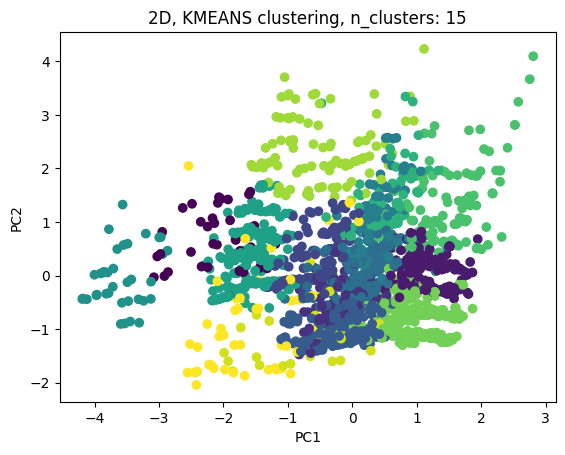

In [ ]:
kmeans1 = k_means_and_plot(standardized_data, 15)

Obtained results of K-Means (with 15 clusters) clustering are not probably optimal. As clusters are overlapping a lot, also located very near each other. They are separated unclearly.   
Preliminary can be said that silhouette score is not very high(unsatisfactory), but for now cannot be compared objectively , as it is the first model prepared in dataset. Obtained silhouette score suggest us that the points are not perfectly similar within cluster to which they are assigned.

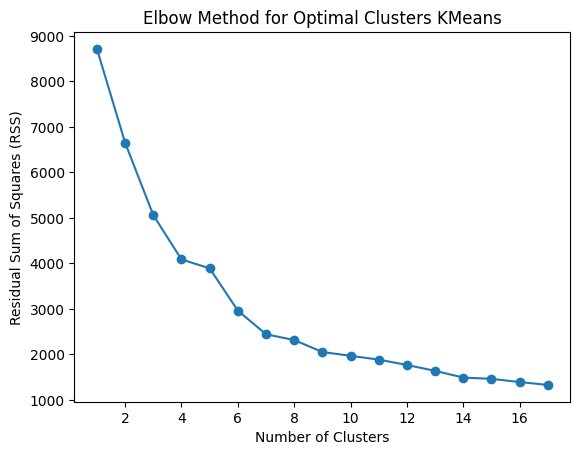

In [ ]:
inertia = []
cluster_range = range(1, 18)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(standardized_data)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Residual Sum of Squares (RSS)")
plt.show()

Using elbow method can be concluded that the optimal number is probably a value 7. After this value the decrease speed of RSS slows down significantly.
Could be chosen another optimal value for number of clusters using this method, like 4, but I guess such number of cluster will not be enough, basing on 3d visualization of dataset.

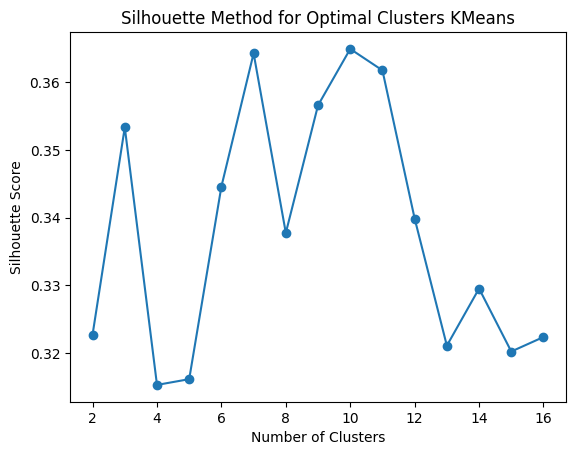

In [ ]:
silhouette_scores = []
cluster_range = range(2, 17)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(standardized_data)
    score = silhouette_score(standardized_data, labels)
    silhouette_scores.append(score)

plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Method for Optimal Clusters KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

Can be seen that Silhouette score is at its maximum value when number of clusters are 3, 7, 9, 10, 11. The difference in values of silhouette score for those number of clusters is not differing very significantly (around value 0.36).   
Will be chosen for KMeans optimal number of clusters: 7.
Because such a value was also previously chosen as optimal value for clusters number by elbow method (RRS metric).  
Also such a value of clusters is not huge, so it will easy to visualize and interpret results of clustering.   
Overall, elbow method did not give us obvious value for number of clusters (not very clear elbow point was seen), as well as silhouette score gave a few values for consideration. But both of them were pointing out (very roughly speaking) at value 7 for number of clusters to choose (for K-MEANS).

Silhouette Score: 0.3642522015051752
Calinski-Harabasz Score: 929.5702388438924


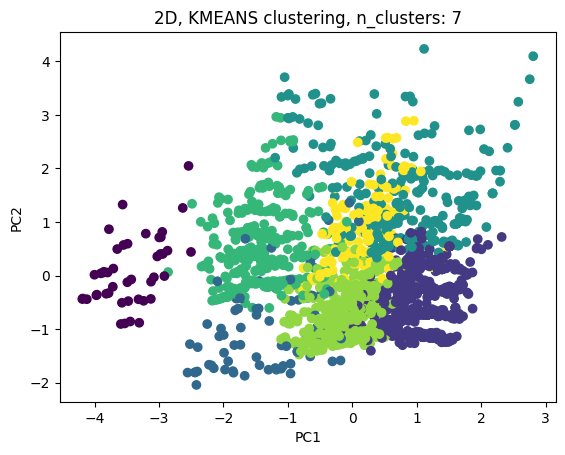

In [ ]:
kmeans2 = k_means_and_plot(standardized_data, 7)

As can be seen Silhouette score and Calinski-Harabasz score are higher for this version of K-Means clustering (clusters = 7), comparing to previous K-Means(clusters=15). So, this time we got better clustering, comparing to previous.
From value of silhoutte score and from 2d visualization can be concluded that clusters overlap somewhat significantly, though partioning is somewhat good, some clusters were detected strangely(most likely not properly). Silhouette score of value 0.36 means that samples are not very densely located to cluster center to which they are assigned.

Silhouette Score: 0.34903311992338093
Calinski-Harabasz Score: 927.7422301881485


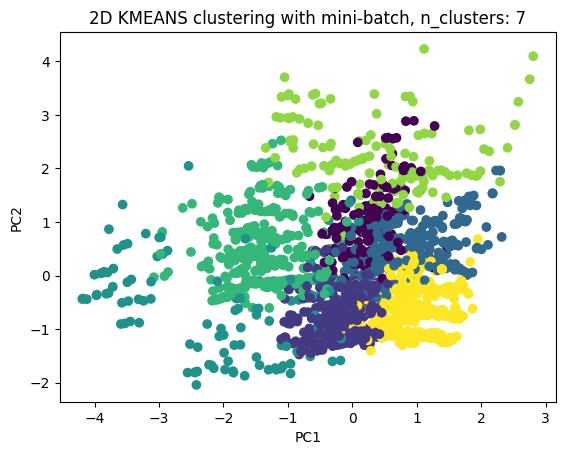

In [ ]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters=7, random_state=1, batch_size=50)
clusters = mini_batch_kmeans.fit_predict(standardized_data)

silhouette = silhouette_score(standardized_data, clusters)
print(f"Silhouette Score: {silhouette}")

calinski_harabasz = calinski_harabasz_score(standardized_data, clusters)
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

pca_df['Cluster'] = clusters

plot = plt.scatter(pca_result[:,0], pca_result[:,1], c=pca_df["Cluster"])
plt.title("2D KMEANS clustering with mini-batch, n_clusters: 7")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

fig_3d = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title="3D KMEANS clustering with mini-batch, n_clusters: 7", opacity=0.7)
fig_3d.show()

Silhouette and Calinski-Harabasz scores has decreased a little bit for K-Means (with mini-batch) comparing to previous the same version of K-Means (but without mini-batch). Can be said that their perfomance is almost the same, but still quality of perfomance reduced for KMeans with mini-batch. It was expected to see worse results for clustering with K-Means with mini batch comparing to K-Means without mini batch (according to theory).

Also, in this case mini batch KMeans algorithm did not identify as separate one visible group of points(at least one), which were merged with another bigger distinct grouping. That was obviously incorrectly labeled.

Labels obtained from K_means(number of clusters = 7, without mini-batch) will be used for evaluating further clustering algorithms when computing external metrcis. Because KMeans (with number of clusters  = 7, without minibatch) has shown the highets value for metrics (internal: silhouette score and Calinski-Harabasz score) out of all K-Means algorithms seen in this section.

**Further algorithms choice explanation**  
Further will be regarded such techniques to cluster instances from dataset:
- GMM
- HDBSCAN
- Agglomerative clustering  

Will be applied all possible main techniques for clustering, so to see which performs best, and identifies cluster best way. As we are dealing with not easy dataset, initial visualization did not reveal clear separate clusters(as for now we cannot guess shapes of future clusters of our dataset), so will be used every possible algorithm , to try to solve this task with the best possible approach.

From 3d visualization of compresed dataset (from 4 features to 3 features) could be concluded that maybe hdbscan will perform the best job on such dataset. As points on 3d plot were located with different densities in space.

Also will be applied main hyperparameters tuning to every of the mentioned clustering tehnique. The focus during hyperparameters tuning will be on maximizing silhouette score.


**GMM**

For GMM the main hyperparameter is the number of models (gaussian distributions) that will be tried to fit to dataset by algorithm. In simple words this hyperparameter determines the number of clusters on which our dataset will be divided.

Best number of clusters: 2
Best Silhouette Score: 0.31776052268038624


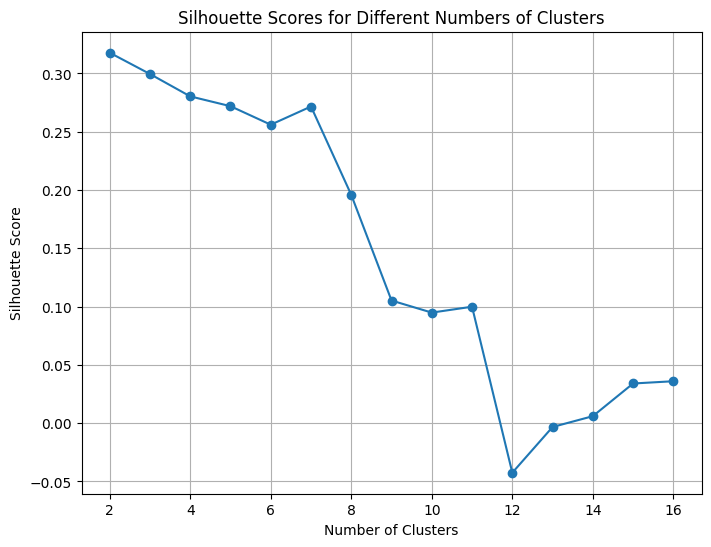

In [ ]:
best_score = -1
best_n_clusters = None
silhouette_scores = []
cluster_range = range(2, 17)

for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=1)
    cluster_labels = gmm.fit_predict(standardized_data)
    score = silhouette_score(standardized_data, cluster_labels)
    silhouette_scores.append(score)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Best number of clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_score}")

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

Will be chosen n_components equal to 7, as it is not very low value for this hyperparameter. And also gives pretty high value for Silhouette score.  
Choosing n_components = 2 (the value of hyperparameter, with which algorithm takes on the maximum silhouette score) would not be correct, as apparently it would lead to very rough partioning of data set samples on only two groups.  
Also we know, that there are 7 ground truth labels, so again it would not be good decision to use n_clusters parameter equal to only 2.

In [ ]:
def gmm_train_plot(n_components, true_labels, data):
  gmm = GaussianMixture(n_components=n_components, random_state=1)
  clusters = gmm.fit_predict(data)

  silhouette = silhouette_score(data, clusters)
  calinski_harabasz = calinski_harabasz_score(data, clusters)

  print(f"Silhouette Score: {silhouette}")
  print(f"Calinski-Harabasz Score: {calinski_harabasz}")

  adjusted_rand = adjusted_rand_score(true_labels, clusters)
  mutual_info = adjusted_mutual_info_score(true_labels, clusters)

  print(f"Adjusted Rand Index: {adjusted_rand}")
  print(f"Adjusted Mutual Information: {mutual_info}")

  pca_df['Cluster'] = clusters

  plot = plt.scatter(pca_result[:,0], pca_result[:,1], c=pca_df["Cluster"])
  plt.title(f"2D GMM Clustering n_clusters: {n_components}")
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.show()

  fig_3d = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title=f"3D GMM Clustering n_clusters: {n_components}", opacity=0.7)
  fig_3d.show()

Silhouette Score: 0.2716295858356172
Calinski-Harabasz Score: 483.7432389425129
Adjusted Rand Index: 0.6444517611169843
Adjusted Mutual Information: 0.6495245732399648


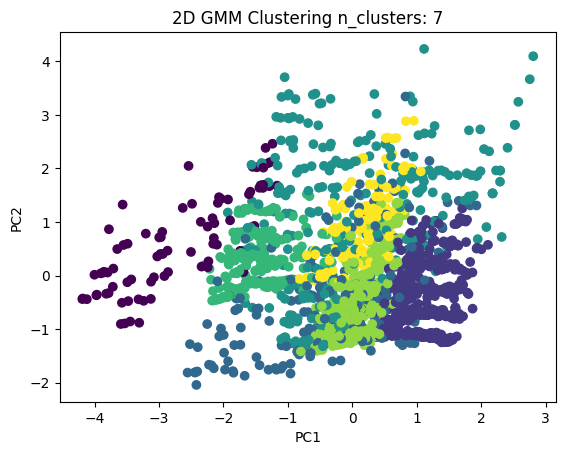

In [ ]:
gmm_train_plot(7, kmeans2, standardized_data)

The silhouette score in this case is lower than for KMeans(without mini batch, n_clusters = 7), in this case is equal to 0.27. As well, are lower Calinski-Harabasz score(same comparison). That means that clustered data points are even more spread out from the center of cluster to which they were assigned(same comparison).  
Adjusted Rand Index = 0.64 and Adjusted Mutual Information: 0.65 which suggest us GMM has clustered samples from dataset in pretty similiar way  as have done K-Means(without mini-batch and n_clusters = 7), though significant differences exist.  
We can conclude for now looking at internal and extrenal metrics, that still the best clustering algorithm is K-Means(n_clusters=7, without minibatch).

**HDBSCAN**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

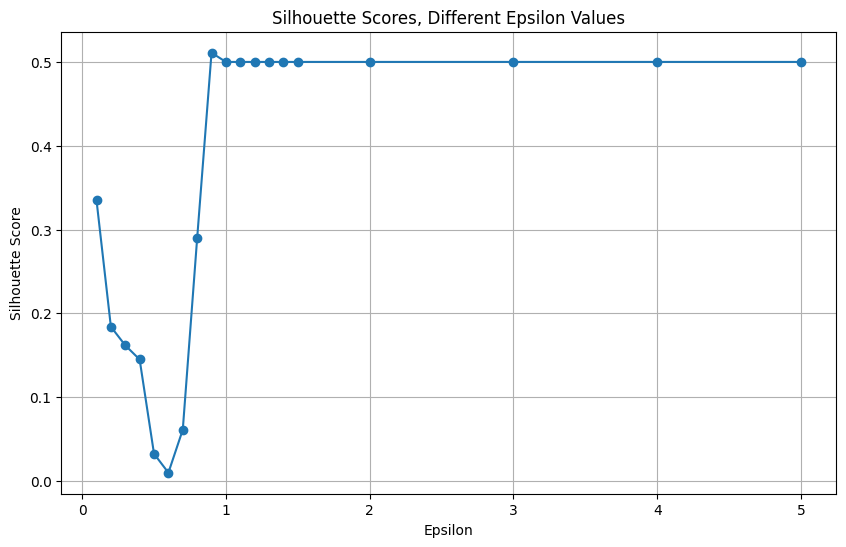

Best epsilon: 0.9
Best Silhouette Score: 0.5110868400190064


In [ ]:
best_score = -1
best_epsilon = None

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5]
min_samples = 5

results = []

for eps in eps_values:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_samples, cluster_selection_epsilon=eps)
    clusters = clusterer.fit_predict(standardized_data)

    valid_clusters = clusters[clusters != -1]
    valid_data = standardized_data[clusters != -1]

    if len(set(valid_clusters)) > 1:
        score = silhouette_score(valid_data, valid_clusters)
        results.append({'epsilon': eps, 'silhouette_score': score})
        if score > best_score:
            best_score = score
            best_epsilon = eps

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['epsilon'], results_df['silhouette_score'], marker='o')
plt.title("Silhouette Scores, Different Epsilon Values")
plt.xlabel("Epsilon")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

print(f"Best epsilon: {best_epsilon}")
print(f"Best Silhouette Score: {best_score}")

There are two main hyperparameters for hdbscan (min_cluster_size and cluster_selection_epsilon), will be tuned only second hyperparameter, the value of first one will be set to default vlaue features_in_dataset+1 (which is motivated by theory knowledge and equal to 5).

The silhouette score was calculated not taking in account samples marked as outliers.

Can be seen that after hyperparameters tuning was identified best value for hyperparameter cluster_selection_epsilon = 0.9.

Hyperparameters 1) min_cluster_size and 2) cluster_selection_epsilon mean:  
1) the number of samples close to each other needed to form one minimal sized cluster;  
2) the distance value that represents neighboorhood of one sample

In [ ]:
def hdbscan_train_plot(eps, min_samples, true_labels, data, pca_result):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_samples, cluster_selection_epsilon=eps)
    clusters = clusterer.fit_predict(data)

    valid_clusters = clusters[clusters != -1]
    valid_data = data[clusters != -1]

    if len(set(valid_clusters)) > 1:
        silhouette = silhouette_score(valid_data, valid_clusters)
        calinski_harabasz = calinski_harabasz_score(valid_data, valid_clusters)
    else:
        silhouette = "all noise"
        calinski_harabasz = "all noise"

    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")

    adjusted_rand = adjusted_rand_score(true_labels, clusters)
    mutual_info = adjusted_mutual_info_score(true_labels, clusters)

    print(f"Adjusted Rand Index: {adjusted_rand}")
    print(f"Adjusted Mutual Information: {mutual_info}")

    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
    pca_df["Cluster"] = clusters

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap="viridis", alpha=0.7)
    plt.title(f"2D HDBSCAN Clustering, eps: {eps}, min_samples: {min_samples}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()

    fig_3d = px.scatter_3d(pca_df,x="PC1",y="PC2",z="PC3",color="Cluster",title=f"3D HDBSCAN Clustering, eps: {eps}, min_samples: {min_samples}",opacity=0.7)
    fig_3d.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Silhouette Score: 0.5110868400190064
Calinski-Harabasz Score: 91.66561270342996
Adjusted Rand Index: 0.030966771486254378
Adjusted Mutual Information: 0.10296161798309955


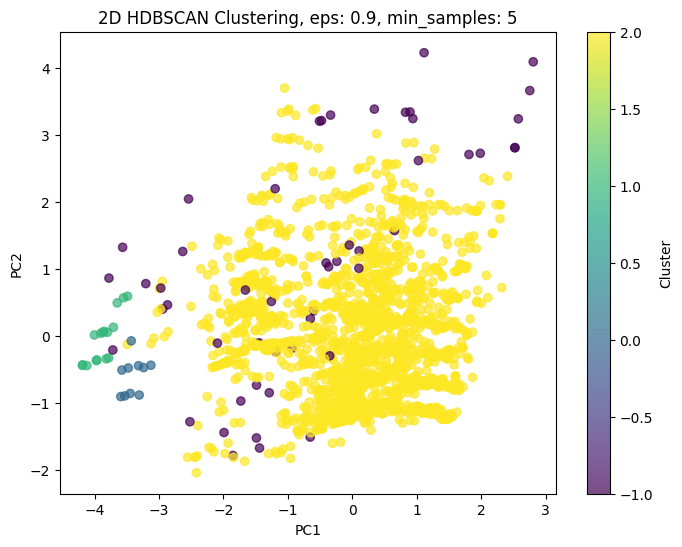

In [ ]:
hdbs = hdbscan_train_plot(0.9, 5, kmeans2, standardized_data, pca_result)

The best hyperparameters were have chosen to maximize silhouette score. Indeed, HDBscan has not performed very good, with creating one huge cluster, two very small ones and marking small amount of samples as outliers. Which led to the highest seen in notebook silhouette score, very low external metrics(which makes this clustering the worse) (the algorithm clustering results do not align with ground truth labels, two external metrics are near zero).  
Moderately high Silhouette (near value of 0.5) score means that on average every point is moderately similiar to other points within its cluster(should be taken into account that mostly one cluster is used across all samples of dataset, that is why silhouette score is moderately high).
From another side, If we look at Calinski-Harabasz scores, we will be able to note that in this case HDBSCAN was worse than K_Means(n_clusters=7, without minibatch). As its calinski-harabasz score 10 times lower comparing to K_means.

**Agglomerative Clustering**

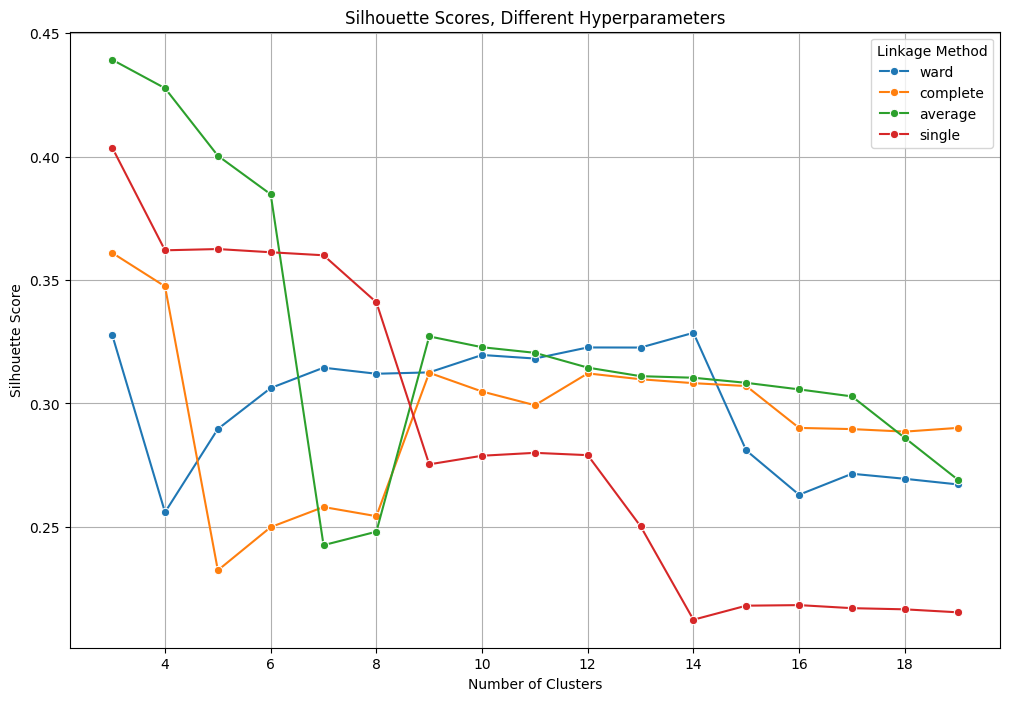

Best parameters: {'n_clusters': 3, 'linkage': 'average'}
Best Silhouette Score: 0.4392197304841378


In [ ]:
best_score = -1
best_params = None

n_clusters_range = range(3, 20)
linkage_methods = ['ward', 'complete', 'average', 'single']

results = []

for n_clusters in n_clusters_range:
    for linkage in linkage_methods:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = model.fit_predict(standardized_data)

        if len(set(cluster_labels)) > 1:
            score = silhouette_score(standardized_data, cluster_labels)
            results.append({'n_clusters': n_clusters, 'linkage': linkage, 'silhouette_score': score})
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage}

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='n_clusters', y='silhouette_score', hue='linkage', marker='o')
plt.title("Silhouette Scores, Different Hyperparameters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Linkage Method")
plt.grid(True)
plt.show()

print(f"Best parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")


Can be seen that maximum value of silhouette score is obtained for hyperparameters linkage='average' and n_clusters=3, it is obvious that estimated number of clusters is too small for our case.  
So will be tried firstly another hyperparameters that maximize silhouette score: linkage='average' and n_clusters = 6. As  can be seen with this set of hyperparameters the silhouette score is pretty high, simultaneously with satisfactory value for n_clusters(6).

In [ ]:
def agglomerative_train_plot(n_clusters, linkage, true_labels, data, pca_result):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    clusters = model.fit_predict(data)

    silhouette = silhouette_score(data, clusters)
    calinski_harabasz = calinski_harabasz_score(data, clusters)

    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")

    adjusted_rand = adjusted_rand_score(true_labels, clusters)
    mutual_info = adjusted_mutual_info_score(true_labels, clusters)

    print(f"Adjusted Rand Index: {adjusted_rand}")
    print(f"Adjusted Mutual Information: {mutual_info}")

    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
    pca_df["Cluster"] = clusters

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap="viridis", alpha=0.7)
    plt.title(f"2D Agglomerative Clustering n_clusters: {n_clusters}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()

    fig_3d = px.scatter_3d(pca_df,x="PC1",y="PC2",z="PC3",color="Cluster",title=f"3D Agglomerative Clustering n_clusters: {n_clusters}",opacity=0.7,)
    fig_3d.show()

Silhouette Score: 0.38470618413601165
Calinski-Harabasz Score: 146.98518939967735
Adjusted Rand Index: 0.06373567218141013
Adjusted Mutual Information: 0.25278113138387376


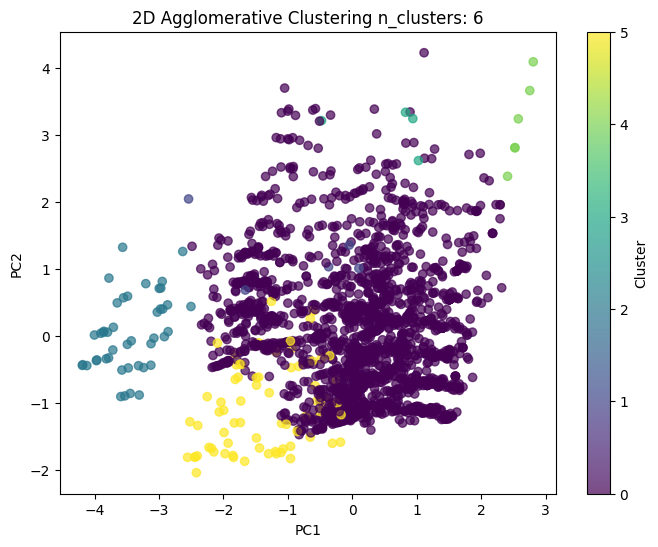

In [ ]:
agglomerative_train_plot(6, 'average', kmeans2, standardized_data, pca_result)

After visualizing and assessing clustering technique can be seen that external metrics are very low, which tells us that algorithm performs poorly(in comparison with labels created by KMeans n_clusters = 7, without mini-batch). Also after visual inspection can be seen that algorithm identified one disproportionaly huge cluster, all 5 others very small. Results obtained are not good, algorithm with such hyperparameters settings is not suitable.

Will be tried another set of hyperparameters, for linkage hyperparameter will be chosen classical value "ward" and for n_clusters value of 7. Those parameetrs were chosen based on plot of silhouette score dependency from hyperparamaetrs. If we take only line that corresponds to "ward" linkage , we will notice that line is maximized in two points (n_clusters = 7 and n_clusters = 14). The smallest value of these two will be chosen, so to make clustering visually more pleasant.


Silhouette Score: 0.3144719257287331
Calinski-Harabasz Score: 741.8216472079804
Adjusted Rand Index: 0.618337001930958
Adjusted Mutual Information: 0.6383306697214073


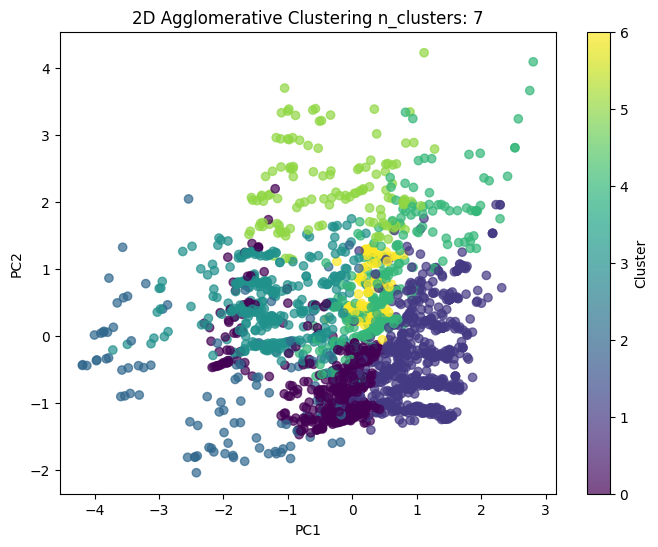

In [ ]:
agglomerative_train_plot(7, 'ward', kmeans2, standardized_data, pca_result)

After setting n_cluster parameter to 7 and linkage parameter to "Ward", can be seen that silhouette metric is lower than for baseline K_Means algorithm and also it became smaller comparing to previous agglomerative algorithm. But this time external metrics became much higher(rand index = 0.62 and mutual information = 0.64), suggesting us that clustering was performed in this case similiarly to K_means(without mini-batch, n_cluster=7). Also visually we see than algorithm has done pretty good job.

**Conclusion**  
Best clustering technique was K-Means without mini-batch and with n_clusters=7. It showed the highest silhouette score and highest Calinski-Harabasz score.  

Clusters identified by this algorithm could be interpreted as places on earth with certain geological properties for example. They could represent the places where ocean deepness is highest or places with different intensities(frequencies) of tornado happenings or locations with different height above mean sea level, etc.

**World Map Plot of Results**

In [ ]:
data['Cluster Label'] = kmeans2

fig = px.scatter_geo(data,
    lat='Latitude',
    lon='Longitude',
    color='Cluster Label',
    size='Richter',
    title='Clustering result on world map',
    projection='orthographic',
    hover_name='Cluster Label',
    labels={'Cluster Label': 'Cluster'})

fig.update_geos(showcountries=True, countrycolor="lightgray",
    showcoastlines=True, coastlinecolor="gray")

fig.update_layout(width=1200,
    height=800)

fig.show()

Can be noticed that clustering of samples (that represent different locations on earth) made sense. Clusters represent distict geographical regions, though occasinally clusters intersect, located too close to each other, which means that results are imperfect.